In [1]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [40]:
data = pd.read_csv("C:/Users/luizf/Desktop/MINDS/Datasets/energydata_complete.csv")
data.pop('date')
data.pop('rv1')
data.pop('rv2')
#data.pop('T9')
#data.pop('T6')
#data.pop('Windspeed')
X=data.copy()
X.drop(data.tail(1).index,inplace=True)
X
y=data.copy()
y.loc[max(y.index)+1, :] = None
y=y.shift(-1)
y.dropna(inplace=True)
y

Appliances  lights         T1       RH_1         T2       RH_2  \
0            60.0    30.0  19.890000  46.693333  19.200000  44.722500   
1            50.0    30.0  19.890000  46.300000  19.200000  44.626667   
2            50.0    40.0  19.890000  46.066667  19.200000  44.590000   
3            60.0    40.0  19.890000  46.333333  19.200000  44.530000   
4            50.0    40.0  19.890000  46.026667  19.200000  44.500000   
...           ...     ...        ...        ...        ...        ...   
19729       100.0     0.0  25.566667  46.560000  25.890000  42.025714   
19730        90.0     0.0  25.500000  46.500000  25.754000  42.080000   
19731       270.0    10.0  25.500000  46.596667  25.628571  42.768571   
19732       420.0    10.0  25.500000  46.990000  25.414000  43.036000   
19733       430.0    10.0  25.500000  46.600000  25.264286  42.971429   

              T3       RH_3         T4       RH_4  ...       T8       RH_8  \
0      19.790000  44.790000  19.000000  45.992500  ...  18.2000  48.863333   
1      19.790000  44.933333  18.926667  45.890000  ...  18.2000  48.730000   
2      19.790000  45.000000  18.890000  45.723333  ...  18.1000  48.590000   
3      19.790000  45.000000  18.890000  45.530000  ...  18.1000  48.590000   
4      19.790000  44.933333  18.890000  45.730000  ...  18.1000  48.590000   
...          ...        ...        ...        ...  ...      ...        ...   
19729  27.200000  41.163333  24.700000  45.590000  ...  24.7000  50.074000   
19730  27.133333  41.223333  24.700000  45.590000  ...  24.7000  49.790000   
19731  27.050000  41.690000  24.700000  45.730000  ...  24.7000  49.660000   
19732  26.890000  41.290000  24.700000  45.790000  ...  24.6625  49.518750   
19733  26.823333  41.156667  24.700000  45.963333  ...  24.7360  49.736000   

              T9     RH_9      T_out  Press_mm_hg     RH_out  Windspeed  \
0      17.066667  45.5600   6.483333        733.6  92.000000   6.666667   
1      17.000000  45.5000   6.366667        733.7  92.000000   6.333333   
2      17.000000  45.4000   6.250000        733.8  92.000000   6.000000   
3      17.000000  45.4000   6.133333        733.9  92.000000   5.666667   
4      17.000000  45.2900   6.016667        734.0  92.000000   5.333333   
...          ...      ...        ...          ...        ...        ...   
19729  23.200000  46.7900  22.733333        755.2  55.666667   3.333333   
19730  23.200000  46.7900  22.600000        755.2  56.000000   3.500000   
19731  23.200000  46.7900  22.466667        755.2  56.333333   3.666667   
19732  23.200000  46.8175  22.333333        755.2  56.666667   3.833333   
19733  23.200000  46.8450  22.200000        755.2  57.000000   4.000000   

       Visibility  Tdewpoint  
0       59.166667   5.200000  
1       55.333333   5.100000  
2       51.500000   5.000000  
3       47.666667   4.900000  
4       43.833333   4.800000  
...           ...        ...  
19729   23.666667  13.333333  
19730   24.500000  13.300000  
19731   25.333333  13.266667  
19732   26.166667  13.233333  
19733   27.000000  13.200000  

[19734 rows x 26 columns]

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train, X_test = train_test_split(X, test_size=0.25, shuffle=False)
X_train, X_val = train_test_split(X_train, test_size=0.15, shuffle=False)
X_train = scaler.fit_transform(X_train.values)
X_val = scaler.fit_transform(X_val.values)
train_loader = torch.utils.data.DataLoader(torch.tensor(X_train.astype(np.float32)), batch_size=32)
val_loader = torch.utils.data.DataLoader(torch.tensor(X_val.astype(np.float32)), batch_size=32)

y_train, y_test = train_test_split(y, test_size=0.25, shuffle=False)
y_train, y_val = train_test_split(y_train, test_size=0.15, shuffle=False)
y_train = scaler.fit_transform(y_train.values)
y_val = scaler.fit_transform(y_val.values)

In [42]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        if torch.cuda.is_available():
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()
        else:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        if torch.cuda.is_available():
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()
        else:
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [43]:
def train_lstm(X_train, layer_dim, dropout_prob, epochs, batch_size, learning_rate, step_wdecay, gamma_wdecay, X_val=0):
    train_loader = torch.utils.data.DataLoader(torch.tensor(X_train.astype(np.float32)), batch_size=batch_size, shuffle=False)
    #val_loader = torch.utils.data.DataLoader(torch.tensor(X_val.astype(np.float32)), batch_size=batch_size,shuffle=False)
    if torch.cuda.is_available():
        y_train_t= torch.tensor(y_train.astype(np.float32)).cuda()
        #y_val_t = torch.tensor(y_val.astype(np.float32)).cuda()
    else:
        y_train_t = torch.tensor(y_train.astype(np.float32))
        #y_val_t = torch.tensor(y_val.astype(np.float32))
    torch.manual_seed(1)
    alpha = 0.5
    h=round(X_train.shape[0]/(alpha * (X_train.shape[1]*2)))
    model = LSTMModel(X_train.shape[1],h, layer_dim,X_train.shape[1],dropout_prob)
    if torch.cuda.is_available():
        model = model.cuda()
    else:
        model = model.cuda()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    buffer = 10000
    steplr = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_wdecay, gamma=gamma_wdecay)

    min_valid_loss=500
    for epoch in range(epochs):
        aux,aux2=0,0
        train_loss=0.0
        model.train()
        for batch, d in enumerate(train_loader):
            if torch.cuda.is_available():
                d =d.cuda()
            optimizer.zero_grad()  #set gradient to 0
            output = model(d.reshape(-1, d.shape[1]).unsqueeze(1))  #make a prediction
            if torch.cuda.is_available():
                loss = criterion(output, y_train_t[aux:aux+d.shape[0]])
            else:
                loss = criterion(output, torch.tensor(y_train_t[aux:aux+d.shape[0]].astype(np.float32)))  #calculate the loss
            loss.backward()  #differentiate loss with respect to parameters
            optimizer.step() #apply the method step and updates the parameters 
            train_loss += loss.item()
            aux+=d.shape[0]
        steplr.step()

        #valid_loss = 0.0
        #model.eval() 
        #for dv in val_loader:  
        #    if torch.cuda.is_available():
        #        dv =dv.cuda()  
        #    target = model(dv.unsqueeze(1))
        #    if torch.cuda.is_available():
        #        val_loss = criterion(target, y_val_t[aux2:aux2+dv.shape[0]])
        #    else:
        #        val_loss = criterion(target,torch.tensor(y_val_t[aux2:aux2+dv.shape[0]].astype(np.float32)))
        #    valid_loss += val_loss.item()
        #    aux2+=dv.shape[0]
        #print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(val_loader)}')
        #if valid_loss < buffer:
        #    buffer = valid_loss
#
   # print (buffer/len(val_loader))   
    return model

In [44]:
def cal_nrmse(rmse, y):
    x = max(y)-min(y)
    return (rmse/x)

In [45]:
n_windows = 30
w = round(len(X)/n_windows)
buffer =  {
         "window": [],
         "rmse": [],
         "mape": [],
         "mae": [],
         "r2": [],
         "smape":[],
         "nrmse":[],
         "variable":[]
    }
    
col = ["window","rmse","mape","mae","r2","variable"]
result = pd.DataFrame(columns=col)
a={}
for i in range(n_windows):
    dfx=X.iloc[int(w*i):int(w*(i+1)), :]
    dfy=y.iloc[int(w*i):int(w*(i+1)), :]
    scaler = StandardScaler()
    X_train, X_test = train_test_split(dfx, test_size=0.25, shuffle=False)
    #X_train, X_val = train_test_split(X_train, test_size=0.15, shuffle=False)
    X_train = scaler.fit_transform(X_train.values)
    #X_val = scaler.fit_transform(X_val.values)


    y_train, y_test = train_test_split(dfy, test_size=0.25, shuffle=False)
    #y_train, y_val = train_test_split(y_train, test_size=0.15, shuffle=False)
    y_train = scaler.fit_transform(y_train.values)
    #y_val = scaler.fit_transform(y_val.values)

    model = train_lstm(X_train, layer_dim=1, dropout_prob=0, epochs=300, batch_size=64, learning_rate=0.001, step_wdecay=50, gamma_wdecay=0.5)

    model.eval()
    if torch.cuda.is_available():
        test_norm= torch.tensor(scaler.fit_transform(X_test.values.astype(np.float32))).cuda()
    else:
        test_norm= torch.tensor(scaler.fit_transform(X_test.values.astype(np.float32)))
    y_norm = scaler.fit_transform(y_test.values)
    #yhat=scaler.inverse_transform(model(test_norm.unsqueeze(1)).detach().numpy())
    yhat=scaler.inverse_transform(model(test_norm.unsqueeze(1)).detach().cpu().numpy())
    #y=scaler.inverse_transform(test_norm.detach().numpy())[:,0]
    
    from pyFTS.benchmarks import Measures
    buffer['rmse']=[Measures.rmse(y_test.values[:,j],yhat[:,j]) for j in range (X.shape[1])]
    buffer['mape']=[Measures.mape(y_test.values[:,j],yhat[:,j]) for j in range (X.shape[1])]
    buffer['mae']=[mean_absolute_error(y_test.values[:,j],yhat[:,j]) for j in range (X.shape[1])]
    buffer['r2']=[r2_score(y_test.values[:,j],yhat[:,j]) for j in range (X.shape[1])]
    buffer['smape']=[Measures.smape(y_test.values[:,j],yhat[:,j]) for j in range (X.shape[1])]
    buffer['nrmse']=[cal_nrmse(Measures.rmse(y_test.values[:,j],yhat[:,j]),y_test.values[:,j]) for j in range (X.shape[1])]
    buffer['variable']=[j for j in X.columns]
    buffer['window']= w*i

    result = pd.concat([result, pd.DataFrame(buffer)], ignore_index=True)
    #result['rmse'].append([j for j in buffer['rmse']])
    #result['mape'].append(buffer['mape'])
    #result['mae'].append(buffer['mae'])
    #result['r2'].append(buffer['r2'])
    #result['variable'].append([j for j in X.columns])
    #result['window'].append(buffer['window'])
#
#result = np.mean(buffer)
#print (result)


    
    


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
C:\Users\luizf\AppData\Local\Temp/ipykernel_27608/1568283450.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  return (rmse/x)
C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.n

In [46]:
result

window       rmse       mape        mae        r2     variable      smape  \
0        0  90.996338  55.657021  58.197195  0.397681   Appliances  32.882595   
1        0   5.165577        inf   3.733283  0.470672       lights  71.987466   
2        0   0.367790   1.377508   0.302578  0.754106           T1   0.687913   
3        0   1.368499   2.082531   0.815139  0.463800         RH_1   1.038660   
4        0   0.369761   1.305393   0.272957  0.771861           T2   0.648630   
..     ...        ...        ...        ...       ...          ...        ...   
775  19082   0.333264   0.035347   0.267171 -0.172153  Press_mm_hg   0.017674   
776  19082   6.012508   8.423693   5.274387  0.832722       RH_out   4.160907   
777  19082   0.690250  25.715422   0.538934  0.320001    Windspeed  12.195143   
778  19082  11.582435  24.841946   9.829967  0.424805   Visibility  11.527366   
779  19082   0.615427   4.605054   0.503862  0.811607    Tdewpoint   2.280928   

        nrmse  
0    0.189576  
1    0.172186  
2    0.147116  
3    0.099455  
4    0.110376  
..        ...  
775  0.238046  
776  0.133611  
777  0.230083  
778  0.263237  
779  0.111896  

[780 rows x 8 columns]

In [47]:
final_measures = {'variable':[], 'rmse': [], 'mae': [], 'mape': [], 'r2': [], 'smape':[], 'nrmse':[], 'rmse_std': [], 'mae_std': [], 'mape_std': [], 'r2_std': [], 'smape_std':[], 'nrmse_std':[]}
m=[]
for i in list(X.columns):
    m=result[result.variable==i].mean()
    st = result[result.variable==i].std()
    final_measures['variable'].append(i)
    final_measures['rmse'].append(m['rmse'])
    final_measures['mae'].append(m['mae'])
    final_measures['mape'].append(m['mape'])
    final_measures['r2'].append(m['r2'])
    final_measures['smape'].append(m['smape'])
    final_measures['nrmse'].append(m['nrmse'])
    final_measures['rmse_std'].append(st['rmse'])
    final_measures['mae_std'].append(st['mae'])
    final_measures['mape_std'].append(st['mape'])
    final_measures['r2_std'].append(st['r2'])
    final_measures['smape_std'].append(st['smape'])
    final_measures['nrmse_std'].append(st['nrmse'])
pd.DataFrame(final_measures)

C:\Users\luizf\AppData\Local\Temp/ipykernel_27608/2831257117.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  m=result[result.variable==i].mean()
C:\Users\luizf\AppData\Local\Temp/ipykernel_27608/2831257117.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  st = result[result.variable==i].std()


variable       rmse        mae       mape            r2      smape  \
0    Appliances  78.068311  46.763939  49.650062  2.114777e-01  20.606754   
1        lights   5.901232   4.190555        inf  1.774852e-01  85.780654   
2            T1   0.296867   0.235166   1.102678  7.248899e-01   0.551656   
3          RH_1   1.061526   0.761469   1.884503  5.573821e-01   0.947058   
4            T2   0.508023   0.399597   1.944391  7.493509e-01   0.973382   
5          RH_2   0.993342   0.771069   1.943274  6.946800e-01   0.969131   
6            T3   0.355008   0.278021   1.230560  3.547683e-01   0.615332   
7          RH_3   0.739119   0.570277   1.451071  4.956969e-01   0.727238   
8            T4   0.413764   0.323071   1.596074  4.776011e-01   0.796737   
9          RH_4   0.821802   0.667094   1.704008  4.853101e-01   0.852076   
10           T5   0.338191   0.258041   1.339305  3.879149e-01   0.668846   
11         RH_5   4.974312   3.545592   6.705161  3.018912e-01   3.347319   
12           T6   1.424150   1.154587  33.737025  7.311141e-01  12.692614   
13         RH_6   5.673530   4.542096  51.171716 -8.388671e+24  12.829921   
14           T7   0.250702   0.198974   0.998222  3.792738e-01   0.498941   
15         RH_7   1.140188   0.931233   2.634647  6.260310e-01   1.311858   
16           T8   0.390937   0.320238   1.479631  5.188715e-01   0.740412   
17         RH_8   1.484687   1.215508   2.855920  5.944310e-01   1.422089   
18           T9   0.165050   0.134010   0.708836  2.152349e-01   0.354482   
19         RH_9   1.102491   0.892811   2.175458  4.812573e-01   1.084547   
20        T_out   1.046871   0.836797        inf  7.326816e-01  10.112210   
21  Press_mm_hg   1.517533   1.301329   0.172435  1.206239e-01   0.086205   
22       RH_out   4.311125   3.364663   4.688869  7.319439e-01   2.320085   
23    Windspeed   1.121977   0.912261        inf  4.110647e-01  12.478802   
24   Visibility   7.506964   6.024630  16.699202  3.922968e-01   7.867702   
25    Tdewpoint   1.035097   0.845384        inf  3.360327e-01  20.993716   

       nrmse   rmse_std    mae_std   mape_std        r2_std  smape_std  \
0   0.140560  37.213059  24.320566  18.529616  1.209506e-01   6.755447   
1        inf   2.629767   2.340712        NaN  2.175298e-01  12.193683   
2   0.151491   0.152335   0.117475   0.616682  1.519623e-01   0.306621   
3   0.126301   0.447294   0.389550   1.052505  1.978265e-01   0.532724   
4   0.145311   0.190211   0.153740   0.718968  1.339562e-01   0.359772   
5   0.133507   0.496376   0.399165   1.019347  1.696177e-01   0.507797   
6   0.190386   0.198274   0.160041   0.654148  3.253165e-01   0.327073   
7   0.161154   0.372472   0.315875   0.796563  2.279123e-01   0.398908   
8   0.185189   0.263820   0.203077   1.062072  2.462212e-01   0.527284   
9   0.168910   0.334693   0.290414   0.736151  2.602352e-01   0.367764   
10  0.165367   0.218606   0.178562   1.010630  3.747959e-01   0.499928   
11  0.174334   2.603017   1.989056   3.700979  2.527089e-01   1.845279   
12  0.153264   0.623827   0.485542  38.409698  1.698835e-01  11.300767   
13       inf   2.460910   2.134101  85.822370  4.594664e+25  16.190704   
14  0.205848   0.150519   0.114928   0.618729  3.556096e-01   0.309326   
15  0.172351   0.443597   0.371619   1.049598  2.485114e-01   0.523633   
16  0.186290   0.169555   0.149941   0.744611  2.788238e-01   0.372408   
17  0.173359   0.546562   0.484682   1.151446  2.788134e-01   0.567063   
18  0.228668   0.088421   0.071828   0.442067  4.363538e-01   0.220821   
19  0.189472   0.384351   0.315986   0.793275  3.692825e-01   0.395097   
20  0.141404   0.515352   0.400854        NaN  1.887158e-01  10.634159   
21  0.263420   1.095229   0.994341   0.132030  3.772459e-01   0.066001   
22  0.134160   1.648695   1.299251   2.250439  2.064836e-01   1.115715   
23  0.198242   0.733998   0.646452        NaN  3.425726e-01   6.785522   
24  0.222779   3.346689   2.955702   8.068583  1.970418e-01   3.592982   
25 

In [49]:
pd.DataFrame(final_measures).to_csv('lstm_appliances_result.csv')

In [111]:
torch.manual_seed(1)
alpha = 2
h=round(X_train.shape[0]/(alpha * (X_train.shape[1]*2)))
model = LSTMModel(X_train.shape[1],h, 1,X_train.shape[1],0)
if torch.cuda.is_available():
    model = model.cuda()
else:
    model = model.cuda()
criterion = torch.nn.MSELoss()
print (model.parameters())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
buffer = 10000
steplr = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
epochs = 320

min_valid_loss=500
for epoch in range(epochs):
    aux,aux2=0,0
    train_loss=0.0
    model.train()
    for batch, d in enumerate(train_loader):
        if torch.cuda.is_available():
            d =d.cuda()
        optimizer.zero_grad()  #set gradient to 0
        output = model(d.reshape(-1, d.shape[1]).unsqueeze(1))  #make a prediction
        if torch.cuda.is_available():
            loss = criterion(output, y_train_t[aux:aux+d.shape[0]])
        else:
            loss = criterion(output, torch.tensor(y_train_t[aux:aux+d.shape[0]].astype(np.float32)))  #calculate the loss
        loss.backward()  #differentiate loss with respect to parameters
        optimizer.step() #apply the method step and updates the parameters 
        train_loss += loss.item()
        aux+=d.shape[0]
    steplr.step()

    valid_loss = 0.0
    model.eval() 
    for dv in val_loader:  
        if torch.cuda.is_available():
            dv =dv.cuda()  
        target = model(dv.unsqueeze(1))
        if torch.cuda.is_available():
            val_loss = criterion(target, y_val_t[aux2:aux2+dv.shape[0]])
        else:
            val_loss = criterion(target,torch.tensor(y_val_t[aux2:aux2+dv.shape[0]].astype(np.float32)))
        valid_loss += val_loss.item()
        aux2+=dv.shape[0]
    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(val_loader)}')
    if valid_loss < buffer:
        buffer = valid_loss

print (buffer/len(val_loader))   
    #if min_valid_loss > valid_loss:
     #   print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f})')
      #  min_valid_loss = valid_loss

C:\Users\luizf\miniconda3\envs\test\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


<generator object Module.parameters at 0x000001302504B2E0>
tensor([[[-1.7639e-04, -5.5214e-04,  7.5940e-03,  ..., -2.5195e-04,
           4.0040e-02, -7.9908e-04]],

        [[-1.6867e-04, -5.6029e-04,  5.7086e-03,  ..., -2.4645e-04,
           3.8267e-02, -7.9896e-04]],

        [[-1.5744e-04, -5.6746e-04,  4.5386e-03,  ..., -2.4989e-04,
           3.7307e-02, -7.9199e-04]],

        ...,

        [[-1.1652e-04, -6.7746e-04, -5.1109e-05,  ..., -3.1282e-04,
           4.1329e-02, -9.1663e-04]],

        [[-9.8464e-05, -6.7725e-04, -4.1514e-05,  ..., -3.3056e-04,
           4.1014e-02, -9.2001e-04]],

        [[-7.7257e-05, -6.2851e-04, -5.6540e-05,  ..., -4.1955e-04,
           3.6711e-02, -8.7867e-04]]], device='cuda:0',
       grad_fn=<LeakyReluBackward1>)


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [32, 1, 55]], which is output 0 of CudnnRnnBackward0, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [99]:
model.eval()
if torch.cuda.is_available():
    test_norm= torch.tensor(scaler.fit_transform(X_test.values.astype(np.float32))).cuda()
else:
    test_norm= torch.tensor(scaler.fit_transform(X_test.values.astype(np.float32)))
y_norm = scaler.fit_transform(y_test.values)
#yhat=scaler.inverse_transform(model(test_norm.unsqueeze(1)).detach().numpy())
yhat=model(test_norm.unsqueeze(1)).detach().cpu().numpy()
#y=scaler.inverse_transform(test_norm.detach().numpy())[:,0]

from pyFTS.benchmarks import Measures
buffer=[Measures.rmse(y_norm[:,i],yhat[:,i]) for i in range (X.shape[1])]
result = np.mean(buffer)
print (result)

0.02753593302994971


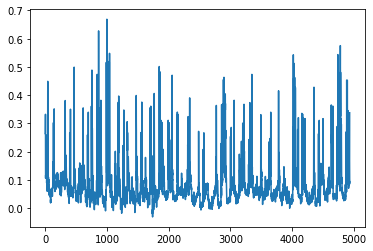

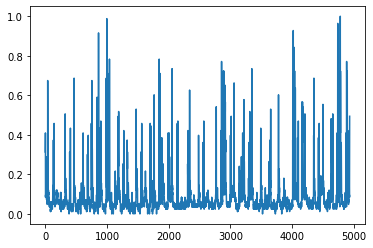

In [58]:
import matplotlib.pyplot as plt
plt.plot(yhat[:,0])
plt.show()
plt.plot (y_norm[:,0])

In [59]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        if torch.cuda.is_available():
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()
        else:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [8]:
torch.manual_seed(1)
model = LSTMModel(X_train.shape[1],150, 2,X_train.shape[1],0)
if torch.cuda.is_available():
    model = model.cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
buffer = 10000

epochs = 20

min_valid_loss=500
for epoch in range(epochs):
    aux,aux2=0,0
    train_loss=0.0
    model.train()
    for batch, d in enumerate(train_loader):
        if torch.cuda.is_available():
            d =d.cuda()
        optimizer.zero_grad()  #set gradient to 0
        output = model(d.reshape(-1, d.shape[1]).unsqueeze(1))  #make a prediction
        if torch.cuda.is_available():
            loss = criterion(output, y_train_t[aux:aux+d.shape[0]])
        else:
            loss = criterion(output, torch.tensor(y_train_t[aux:aux+d.shape[0]].astype(np.float32)))  #calculate the loss
        loss.backward()  #differentiate loss with respect to parameters
        optimizer.step() #apply the method step and updates the parameters 
        train_loss += loss.item()
        aux+=d.shape[0]

    valid_loss = 0.0
    model.eval() 
    for dv in val_loader: 
        if torch.cuda.is_available():
            dv =dv.cuda()   
        target = model(dv.unsqueeze(1))
        if torch.cuda.is_available():
            val_loss = criterion(target, y_val_t[aux2:aux2+dv.shape[0]])
        else:
            val_loss = criterion(target,torch.tensor(y_val_t[aux2:aux2+dv.shape[0]].astype(np.float32)))
        valid_loss += val_loss.item()
        aux2+=dv.shape[0]
    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(val_loader)}')
    if valid_loss < buffer:
        buffer = valid_loss

print (buffer/len(val_loader))   
    #if min_valid_loss > valid_loss:
     #   print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f})')
      #  min_valid_loss = valid_loss

NameError: name 'y_train_t' is not defined

In [23]:
model.eval()
if torch.cuda.is_available():
    test_norm= torch.tensor(scaler.fit_transform(X_test.values.astype(np.float32))).cuda()
else:
    test_norm= torch.tensor(scaler.fit_transform(X_test.values.astype(np.float32)))
y_norm = scaler.fit_transform(y_test.values)
#yhat=scaler.inverse_transform(model(test_norm.unsqueeze(1)).detach().numpy())
yhat=model(test_norm.unsqueeze(1)).detach().cpu().numpy()
#y=scaler.inverse_transform(test_norm.detach().numpy())[:,0]

from pyFTS.benchmarks import Measures
buffer=[Measures.rmse(y_norm[:,i],yhat[:,i]) for i in range (X.shape[1])]
result = np.mean(buffer)
print (result)

0.06911269190394034


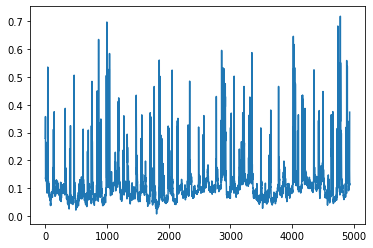

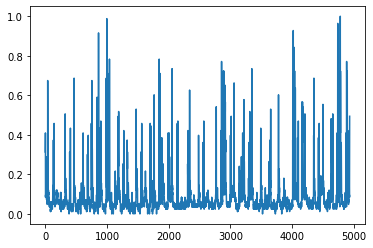

In [20]:
import matplotlib.pyplot as plt
plt.plot(yhat[:,0])
plt.show()
plt.plot (y_norm[:,0])

In [24]:
print (model)

GRUModel(
  (gru): GRU(22, 20, num_layers=4, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)
